# AN Plots
This notebook is used to collect some of the code used to produce the plots particularly for the analysis note AN-22-133.

In [6]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import hist
import mplhep as hep
import warnings
from plot_utils import *
import fill_utils

warnings.filterwarnings('ignore')
hep.style.use("CMS")
plt.style.use(hep.style.CMS)
matplotlib.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams['figure.dpi'] = 50
matplotlib.rcParams['figure.facecolor'] = 'white'

## Notebook Parameters
The following couple cells define the input and output directories, and load in the desired .pkl files into the `plots` nested dictionary.<br>
`output_label`: _str_, saves plots as `<output_label>+<plot_name>.<file_ext>`.<br>
`file_ext`: _str_, see above.<br>

In [2]:
# parameters
output_label = '/home/submit/lavezzo/public_html/SUEP/analysis/debug/'
AN_label = '/home/submit/lavezzo/SUEP/AN-22-133/images/offline/{}.pdf'
saveToAN = False  # control whether to save to AN directory
file_ext = '.pdf'

The `plots` dictionary is used to store all the plots imported from the pickle files. Dimensions: (sample) x (plot label) <br>
The `loader` function in `plot_utils.py` automatically merges all the QCD HT and QCD pT bins into one sample ('QCD_HT' and 'QCD_Pt'), applies the lumis, and excludes some of the low QCD bins.<br>

In [3]:
# create output dir
if not os.path.isdir(output_label): 
    print("Creating", output_label)
    os.mkdir(output_label)

# This part is meant to be flxeible, depending on what you want to import
# dimensions: (sample) x (plot label)

# input .pkl files
plotDir = '/work/submit/{}/SUEP/outputs/'.format(os.environ['USER'])
infile_names = glob.glob(plotDir+'*.pkl')

# generate list of files that you want to merge histograms for
offline_files_SUEP = [f for f in infile_names if "ISR_closure_v2.pkl" in f and ('generic' in f)]
offline_files_2018 = [f for f in infile_names if "ISR_closure_v2.pkl" in f and ('20UL18' in f or 'Run2018' in f)]
offline_files_2017 = [f for f in infile_names if "ISR_closure_v2.pkl" in f and ('20UL17' in f or 'Run2017' in f)]
offline_files_2016 = [f for f in infile_names if "ISR_closure_v2.pkl" in f and ('20UL16' in f or 'Run2016' in f)]

# merge the histograms, apply lumis, exclude low HT bins
plots_SUEP_2018 = loader(offline_files_SUEP, year=2018, exclude_low_bins=True)
# plots_SUEP_2017 = loader(offline_files_SUEP, year=2017, exclude_low_bins=True)
# plots_SUEP_2016 = loader(offline_files_SUEP, year=2016, exclude_low_bins=True)
plots_2018 = loader(offline_files_2018, auto_lumi=True, exclude_low_bins=True)
plots_2017 = loader(offline_files_2017, auto_lumi=True, exclude_low_bins=True)
plots_2016 = loader(offline_files_2016, auto_lumi=True, exclude_low_bins=True)

# put everything in one dictionary
plots = {}
for key in plots_SUEP_2018.keys(): plots[key+"_2018"] = fill_utils.apply_normalization(plots_SUEP_2018[key], fill_utils.getXSection('generic_' + key + '_MD2_T2_HT', '2018', SUEP=True))
# for key in plots_SUEP_2017.keys(): plots[key+"_2017"] = fill_utils.apply_normalization(plots_SUEP_2017[key], fill_utils.getXSection(key + '+RunIIAutumn18-private+MINIAODSIM', '2018', SUEP=True))
# for key in plots_SUEP_2016.keys(): plots[key+"_2016"] = fill_utils.apply_normalization(plots_SUEP_2016[key], fill_utils.getXSection(key + '+RunIIAutumn18-private+MINIAODSIM', '2018', SUEP=True))
for key in plots_2018.keys(): plots[key+"_2018"] = plots_2018[key]
for key in plots_2017.keys(): plots[key+"_2017"] = plots_2017[key]
for key in plots_2016.keys(): plots[key+"_2016"] = plots_2016[key]

These are all the samples loaded.

In [4]:
keys = list(plots.keys())
keys.sort()
for k in keys: print(k)

1000to1500_2016
1000to1500_2017
1000to1500_2018
1500to2000_2016
1500to2000_2017
1500to2000_2018
2000toInf_2016
2000toInf_2017
2000toInf_2018
200to300_2016
200to300_2017
200to300_2018
300to500_2016
300to500_2017
300to500_2018
500to700_2016
500to700_2017
500to700_2018
700to1000_2016
700to1000_2017
M1000_2018
M125_2018
M200_2018
M300_2018
M400_2018
M500_2018
M600_2018
M700_2018
M800_2018
M900_2018
QCD_HT_2016
QCD_HT_2017
QCD_HT_2018
data_2016
data_2017
data_2018


## 1D Comparison

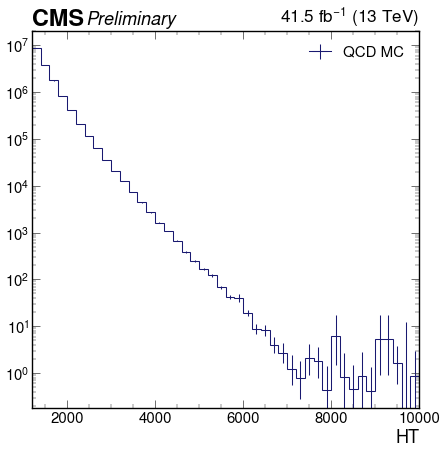

In [7]:
plot_label = 'ht_Cluster'
year = '2017'

samples = ['QCD_HT_'+year]
labels = ['QCD MC', r'$m_{S}=125$ GeV',r'$m_{S}=400$ GeV',r'$m_{S}=750$ GeV',r'$m_{S}=1000$ GeV']
density = False

hep.cms.label(llabel='Preliminary', data=False, lumi=lumiLabel(year))
for label, sample in zip(labels, samples): 
    h = plots[sample][plot_label][::2j]
    if density:
        h = h/h.sum().value
    hep.histplot(h, yerr=True, label=label, color=default_colors[sample]) 

# tweak these by hand, as needed
#plt.ylim(1e0,2e6)
plt.xlim(1200,10000)
plt.legend(loc='best')
plt.yscale("log")

# save and show
if saveToAN: plt.savefig(AN_label.format("HT_"+year))
plt.savefig(output_label+plot_label+"_"+year+file_ext)
plt.show()

## Compare Variables

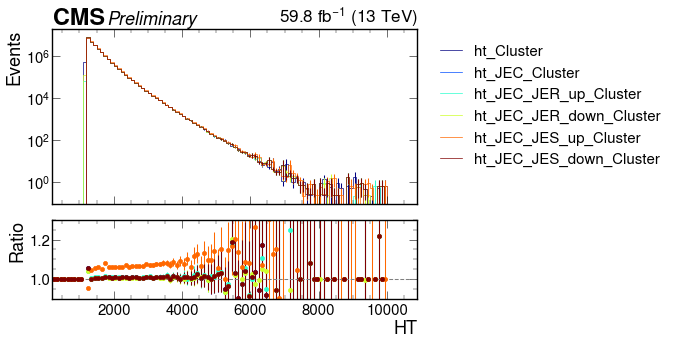

In [8]:
variables = ['ht_Cluster', 'ht_JEC_Cluster', 
             'ht_JEC_JER_up_Cluster', 'ht_JEC_JER_down_Cluster',
             'ht_JEC_JES_up_Cluster', 'ht_JEC_JES_down_Cluster']
year = '2018'
sample = 'QCD_HT_'+year
density = False

hlist = []
for var in variables:
    h = plots[sample][var]
    if density: h = h/h.sum().value
    hlist.append(h)

fig, axs = plot_ratio(hlist, labels=variables)
hep.cms.label(llabel='Preliminary', data=False, lumi=lumiLabel(year), ax=axs[0])
axs[0].legend(bbox_to_anchor=(1.02,1))
axs[1].set_ylim(0.9,1.3)

if saveToAN: fig.savefig(AN_label.format("HT_ratio_"+sample), bbox_inches='tight')
fig.savefig(output_label+"HT_ratio_"+sample+file_ext, bbox_inches='tight')
fig.show()

## SUEP ISR Comparison

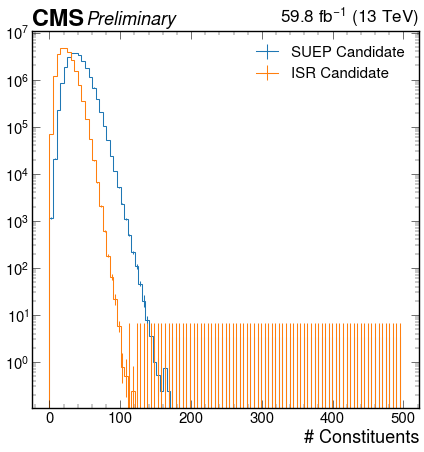

In [9]:
variable = 'nconst'
year = '2018'
sample = 'QCD_HT_{}'.format(year)

plot_labels = ['SUEP_{}_Cluster'.format(variable), 
               'ISR_{}_ClusterInverted'.format(variable)]
objects = ['SUEP Candidate', 'ISR Candidate']

fig, ax = plt.subplots()
hep.cms.label(llabel='Preliminary',data=False, lumi=lumiLabel(year))

for plot_label, obj in zip(plot_labels, objects): 
    h = plots[sample][plot_label][::2j]
    hep.histplot(h, yerr=True, label=obj) 

fig.axes[0].set_yscale("log")
fig.axes[0].legend()

# save and show
if saveToAN:
    plt.savefig(AN_label.format("ISR_SUEP_"+variable))
plt.savefig(output_label+plot_label+"_"+year+file_ext)
plt.show()

## Extended ABCD

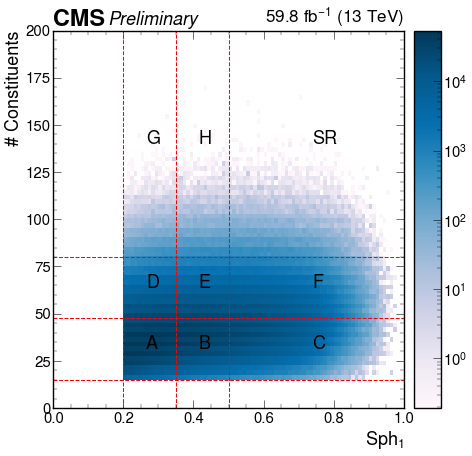

In [10]:
plot_label = '2D_SUEP_S1_vs_SUEP_nconst_Cluster'
sample = 'QCD_HT_2018'
#samples += ['SUEP-m125-generic', 'SUEP-m400-generic', 'SUEP-m750-generic', 'SUEP-m1000-generic']
draw_lines = True
lines_x = [0.2, 0.35, 0.5, 1.0]
lines_y = [15, 47.5, 80, 200]

fig, ax = plt.subplots(figsize=(10, 10))

k = 0
regions = ['A','B','C','D','E','F','G','H','SR']
for i in range(len(lines_y)-1):
    for j in range(len(lines_x)-1):
        xloc = (lines_x[j+1] + lines_x[j])/2 - 0.01
        yloc = (lines_y[i+1] + lines_y[i])/2
        plt.text(xloc, yloc, regions[k])
        k+=1
    
if plots[sample][plot_label].sum().value == 0:
    print("Histogram empty for sample", sample)

h = plots[sample][plot_label]
bins = np.linspace(0,500,10)
h = h[0.2j:,16j::1j]

hep.cms.label(llabel='Preliminary',data=False, lumi=lumiLabel(year))
_ = hep.hist2dplot(h, 
           norm=matplotlib.colors.LogNorm(),
           cmap = 'PuBu',
           cbar=True,
           label=sample) 

# draw lines to visualize ABCD regions
if draw_lines:
    for y in lines_y: plt.plot([0,10000], [y,y], color='red', linestyle='dashed')
    for x in lines_x: plt.plot([x,x], [0,1000], color='red', linestyle='dashed')

plt.ylim(0,200)
plt.xlim(0.0,1.0)

if saveToAN: plt.savefig(AN_label.format("extendedABCD_regions_2018"))
plt.savefig(output_label+""+file_ext)
plt.show()

In [ ]:
plot_label = '2D_SUEP_S1_vs_single_l5_bPfcand_S1_SUEPtracks_GNN'
sample = 'QCD_HT_2018'
#samples += ['SUEP-m125-generic', 'SUEP-m400-generic', 'SUEP-m750-generic', 'SUEP-m1000-generic']
draw_lines = True
lines_x = [0.3,0.4, 0.5, 1.0]
lines_y = [0,0.5,1]

fig, ax = plt.subplots(figsize=(10, 10))

k = 0
regions = ['A','B','C','D','E','SR']
for i in range(len(lines_y)-1):
    for j in range(len(lines_x)-1):
        xloc = (lines_x[j+1] + lines_x[j])/2 - 0.01
        yloc = (lines_y[i+1] + lines_y[i])/2
        plt.text(xloc, yloc, regions[k])
        k+=1
    
if plots[sample][plot_label].sum().value == 0:
    print("Histogram empty for sample", sample)

h = plots[sample][plot_label]
h = h[0.3j:,:]

hep.cms.label(llabel='Preliminary',data=False, lumi=61.0)
_ = hep.hist2dplot(h, 
           norm=matplotlib.colors.LogNorm(),
           cmap = 'PuBu',
           cbar=True,
           label=sample) 

# draw lines to visualize ABCD regions
if draw_lines:
    for y in lines_y: plt.plot([0,10000], [y,y], color='red', linestyle='dashed')
    for x in lines_x: plt.plot([x,x], [0,1000], color='red', linestyle='dashed')

plt.ylim(0,1)
plt.xlim(0.2,1.0)

if saveToAN: plt.savefig(AN_label.format("ML_extendedABCD_regions_2018"))
plt.savefig(output_label+""+file_ext)
plt.show()

## ABCD - QCD Background

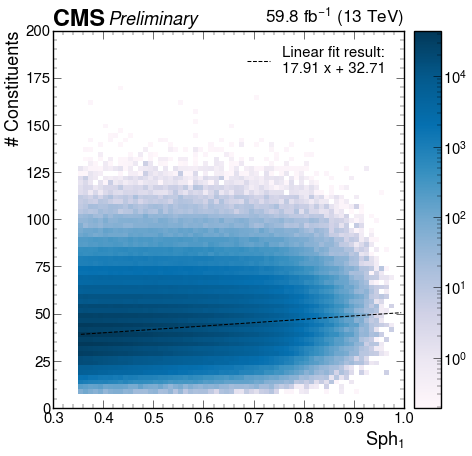

In [12]:
plot_label = '2D_SUEP_S1_vs_SUEP_nconst_Cluster'
year = '2018'
sample = 'QCD_HT_'+year
doLinearFit = True

fig, ax = plt.subplots(figsize=(10, 10))
    
if plots[sample][plot_label].sum().value == 0:
    print("Histogram empty for sample", sample)

h = plots[sample][plot_label]
h = h[0.35j:,10j:]

hep.cms.label(llabel='Preliminary',data=False, lumi=lumiLabel(year))
_ = hep.hist2dplot(h, 
           norm=matplotlib.colors.LogNorm(),
           cmap = 'PuBu',
           cbar=True,
           label=sample) 

if doLinearFit:
    p = linearFit2DHist(h)
    plt.plot(h.axes[0].centers, p(h.axes[0].centers), label="Linear fit result:"+str(p), color='black', linestyle='dashed')

plt.ylim(0,200)
plt.xlim(0.3,1.0)
plt.legend()

if saveToAN: plt.savefig(AN_label.format("2D_decorrelate_"+year))
plt.savefig(output_label+"2D_decorrelate_"+year+file_ext)
plt.show()

## ABCD - MC Closure

Scaling factor alpha: 1.54709726285491
Sigma alpha: 0.0166216473801837
Chi^2: 1.883186242335099


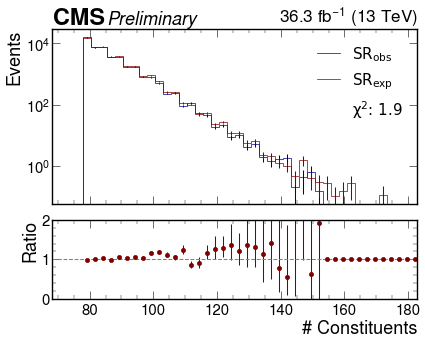

In [13]:
plot_label = '2D_SUEP_S1_vs_SUEP_nconst_Cluster'
year = '2016'
sample = 'QCD_HT'
rebin = False
new_bins = [80, 85, 90, 100, 120, 150]
xregions = [0.2j, 0.35j, 0.5j, 1.0j]
yregions = [15j, 47.5j, 80j, 300j]

abcd = plots["{}_{}".format(sample,year)][plot_label]
SR, SR_exp, alpha, sigma_alpha = ABCD_9regions_errorProp(abcd, xregions, yregions, sum_var='x')

if rebin:
    edges = SR.axes[0].edges
    SR = rebin_piecewise(SR, new_bins)
    SR_exp = rebin_piecewise(SR_exp, new_bins)

print("Scaling factor alpha:", alpha)
print("Sigma alpha:", sigma_alpha)

# pull test
diffs = np.abs(SR_exp.values() - SR.values())
tot_sigma = np.sqrt(SR.variances() + SR_exp.variances())
pull_ratios = np.where(tot_sigma > 0, diffs/tot_sigma, 0) + 1

# chi2 test
tot_sigma = np.sqrt(SR.variances() + SR_exp.variances())
chi2 = np.sum(np.where(tot_sigma > 0, (SR.values() - SR_exp.values())**2 / tot_sigma**2, 0)) / len(tot_sigma[tot_sigma > 0])
print("Chi^2:", chi2)

# use the custom plot_ratio
# the hist implementation used elsewhere in the notebook doesn't use the 
# errors in the hists' bins to calculate the errors in the ratio plot
fig, axs = plot_ratio([SR_exp, SR], labels=["$SR_{obs}$", "$SR_{exp}$"])
#_ = axs[0].scatter([], [], marker='+', label='Pull')
_# = axs[1].scatter(SR.axes[0].centers, pull_ratios, marker='+', label='Pull')
_ = axs[0].plot([],[],' ',label=r'$\chi^2$: {}'.format(round(chi2,1)))
_ = axs[1].set_ylim(0,2)
_ = axs[0].legend(prop={"family":"DejaVu Sans"})
#_ = axs[1].set_yticks(ticks=[0,1,2], labels=['-1','0','1'])
#_ = axs[1].set_ylabel("1 - Ratio")
hep.cms.label(llabel='Preliminary', data=False, lumi=lumiLabel(year), ax=axs[0])

if saveToAN: plt.savefig(AN_label.format("closure_"+sample+"_"+year))
plt.savefig(output_label+"closure_"+year+file_ext)

## ABCD - ISR Closure

Scaling factor alpha: 2.09990898861859
Sigma alpha: 0.131787804728613
1.0705772185402074


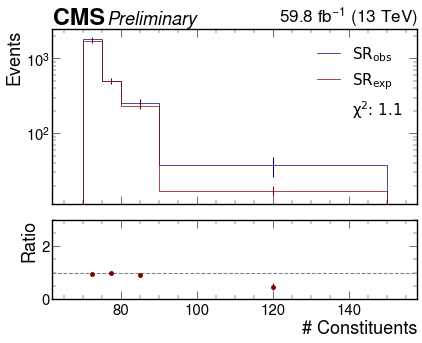

In [14]:
plot_label = '2D_ISR_S1_vs_ISR_nconst_ClusterInverted'
year = '2018'
sample = 'QCD_HT'
rebin = True
xregions = [0.3j, 0.4j, 0.5j, 500j]
yregions = [20j, 45j, 70j, 500j]
new_bins = [70,75,80,90,150]

abcd = plots["{}_{}".format(sample,year)][plot_label]
SR, SR_exp, alpha, sigma_alpha = ABCD_9regions_errorProp(abcd, xregions, yregions, sum_var='x')

if rebin:
    edges = SR.axes[0].edges
    SR = rebin_piecewise(SR, new_bins)
    SR_exp = rebin_piecewise(SR_exp, new_bins)

print("Scaling factor alpha:", alpha)
print("Sigma alpha:", sigma_alpha)

# pull test
diffs = np.abs(SR_exp.values() - SR.values())
tot_sigma = np.sqrt(SR.variances() + SR_exp.variances())
pull_ratios = np.where(tot_sigma > 0, diffs/tot_sigma, 0) + 1

# chi2 test
tot_sigma = np.sqrt(SR.variances() + SR_exp.variances())
chi2 = np.sum(np.where(tot_sigma > 0, (SR.values() - SR_exp.values())**2 / tot_sigma**2, 0)) / len(tot_sigma[tot_sigma > 0])
print(chi2)

# use the custom plot_ratio
# the hist implementation used elsewhere in the notebook doesn't use the 
# errors in the hists' bins to calculate the errors in the ratio plot
fig, axs = plot_ratio([SR_exp, SR], labels=["$SR_{obs}$", "$SR_{exp}$"])
#_ = axs[0].scatter([], [], marker='+', label='Pull')
_# = axs[1].scatter(SR.axes[0].centers, pull_ratios, marker='+', label='Pull')
_ = axs[0].plot([],[],' ',label=r'$\chi^2$: {}'.format(round(chi2,1)))
_ = axs[1].set_ylim(0,3)
_ = axs[0].legend(prop={"family":"DejaVu Sans"})
#_ = axs[1].set_yticks(ticks=[0,1,2], labels=['-1','0','1'])
#_ = axs[1].set_ylabel("1 - Ratio")
hep.cms.label(llabel='Preliminary', data=False, lumi=lumiLabel(year), ax=axs[0])


if saveToAN: plt.savefig(AN_label.format("ISR_closure_"+sample+"_"+year))
plt.savefig(output_label+"ISR_closure_"+year+file_ext)

Scaling factor alpha: 2.09990898861859
Sigma alpha: 0.131787804728613


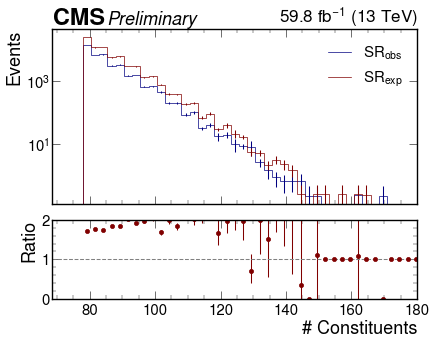

In [15]:
plot_label = '2D_SUEP_S1_vs_SUEP_nconst_Cluster'
year = '2018'

abcd = plots['QCD_HT_'+year][plot_label]

# 2D_SUEP_S1_vs_SUEP_nconst_Cluster
# 2D_ISR_S1_vs_ISR_nconst_ClusterInverted
xregions = [0.35j, 0.5j, 1.0j]
yregions = [10j, 80j, 300j]

# 2D_SUEP_S1_vs_SUEP_nconst_Cluster
# 2D_ISR_S1_vs_ISR_nconst_ClusterInverted
# xregions = [0.35j, 0.4j, 0.5j, 1.0j]
# yregions = [20j, 40j, 60j, 300j]

# 2D_ISR_S1_ISR_nconst_CL
# xregions = [0.35j, 0.4j, 0.5j, 1.0j]
# yregions = [0.0j, 30j, 60j, 300j]

# 2D_SUEP_S1_SUEP_nconst_CL (scouting)
# xregions = [0.35j, 0.4j, 0.5j, 1.0j]
# yregions = [10.0j, 35j, 60j, 300j]

SR, SR_exp = ABCD_4regions(abcd, xregions, yregions, sum_var='x')

print("Scaling factor alpha:", alpha)
print("Sigma alpha:", sigma_alpha)

# use the custom plot_ratio
# the hist implementation used elsewhere in the notebook doesn't use the 
# errors in the hists' bins to calculate the errors in the ratio plot
fig, axs = plot_ratio([SR_exp, SR], labels=["$SR_{obs}$", "$SR_{exp}$"])
_ = axs[1].set_ylim(0,2)
_ = axs[0].legend()
hep.cms.label(llabel='Preliminary', data=False, lumi=lumiLabel(year), ax=axs[0])


if saveToAN: plt.savefig(AN_label.format("closure_"+year))
plt.savefig(output_label+"closure_"+year+file_ext)

## ABCD - MC ML Closure

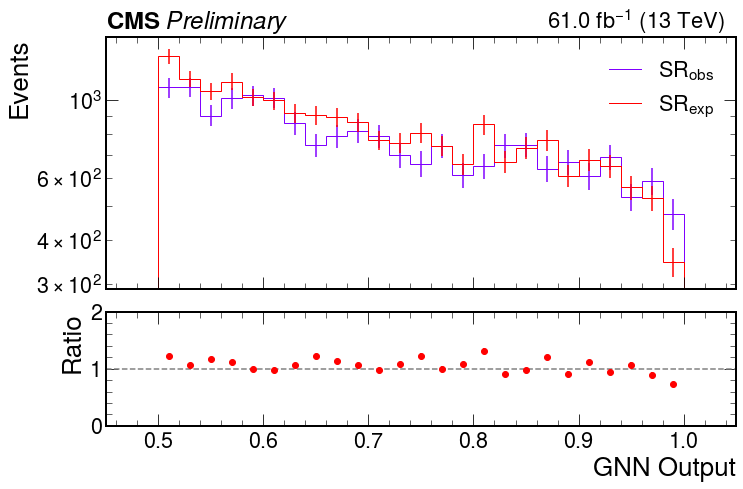

In [43]:
plot_label = '2D_SUEP_S1_vs_single_l5_bPfcand_S1_SUEPtracks_GNN'
year = '2018'
abcd = plots['QCD_HT_'+year][plot_label]

xregions = [0.3j, 0.4j, 0.5j, 1.0j]
yregions = [0.0j, 0.5j, 1.0j]

SR, SR_exp = ABCD_6regions(abcd, xregions, yregions, sum_var='x')

SR = SR[::2j]
SR_exp = SR_exp[::2j]

fig, axs = plot_ratio([SR_exp, SR], labels=["$SR_{obs}$", "$SR_{exp}$"])
_ = axs[1].set_ylim(0,2)
_ = axs[0].legend()
hep.cms.label(llabel='Preliminary', data=False, lumi=lumiLabel(year), ax=axs[0])


if saveToAN: plt.savefig(AN_label.format("ML_closure_"+year))
plt.savefig(output_label+"ML_closure_"+year+file_ext)

## ABCD - Final

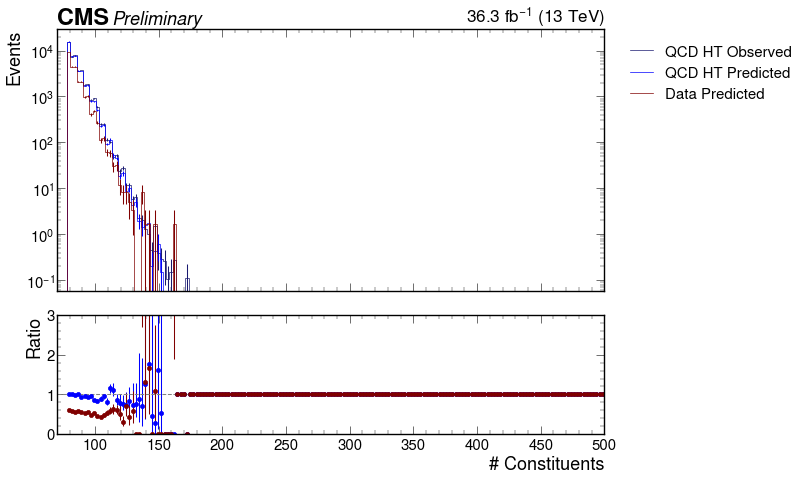

In [16]:
plot_label = '2D_SUEP_S1_vs_SUEP_nconst_Cluster'
year = '2016'
abcd = plots['QCD_HT_'+year][plot_label]
masses = [125, 400, 1000]
xregions = [0.2j, 0.35j, 0.5j, 1.0j]
yregions = [15j, 47.5j, 80j, 500j]

SR, SR_exp, alpha, sigma_alpha = ABCD_9regions_errorProp(abcd, xregions, yregions, sum_var='x')
_, SR_exp_data, _, _ = ABCD_9regions_errorProp(plots['data_'+year][plot_label], xregions, yregions, sum_var='x')

hlist = [SR, SR_exp, SR_exp_data]
colors = [default_colors['QCD_HT'], 'blue', default_colors['data']]
labels = ['QCD HT Observed', 'QCD HT Predicted', 'Data Predicted']
for mass in masses:
    if year is not '2018': continue        #TEMPORARY
    sample = 'M{}_{}'.format(mass, year)
    label = r'$m_{S}={'+str(mass)+'}$ GeV'
    abcd = plots[sample][plot_label]
    SUEP_SR = abcd[0.5j:1.0j:sum, 80j:500j]
    hlist.append(SUEP_SR)
    labels.append(label)
    colors.append(default_colors[sample])

fig, axs = plot_ratio(hlist, labels=labels, cmap=colors)
fig.set_size_inches(15, 15, forward=True)
axs[0].set_xlim(70, 500)
hep.cms.label(llabel='Preliminary', data=False, lumi=lumiLabel(year), ax=axs[0])
axs[0].legend(bbox_to_anchor=(1.02,1))
axs[1].set_ylim(0, 3)

if saveToAN: plt.savefig(AN_label.format("final_"+year))
plt.savefig(output_label+"final_"+year+file_ext)

25939.94692707151 266.98556874908866


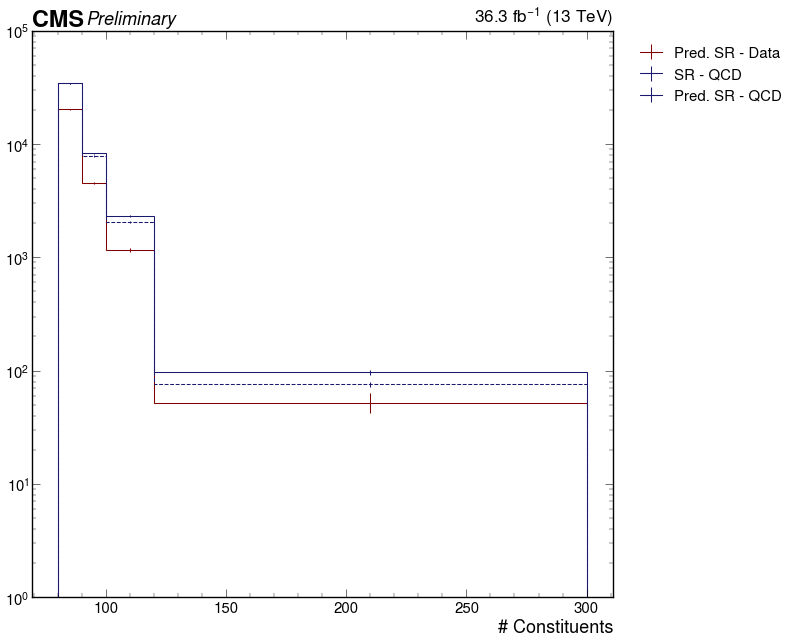

In [17]:
plot_label = '2D_SUEP_S1_vs_SUEP_nconst_Cluster'
year = '2016'
abcd = plots['QCD_HT_'+year][plot_label]

newbins = [80, 90, 100, 120, 300]
xregions = [0.2j, 0.35j, 0.5j, 1.0j]
yregions = [15j, 47.5j, 80j, 300j]
SR, SR_exp, alpha, sigma_alpha = ABCD_9regions_errorProp(abcd, xregions, yregions, sum_var='x')
_, SR_exp_data, _, _ = ABCD_9regions_errorProp(plots['data_'+year][plot_label], xregions, yregions, sum_var='x')

print(SR_exp_data.sum().value, np.sqrt(SR_exp_data.sum().variance))

# use the custom plot_ratio
# the hist implementation used elsewhere in the notebook doesn't use the 
# errors in the hists' bins to calculate the errors in the ratio plot
# fig, axs, _ = plot_ratio(SR_exp, SR, 
#                          "# Constituents in SUEP", "$SR_{obs}$ - QCD", "$SR_{exp}$ - Data")
# _ = axs[1].set_ylim(0,3.0)
# _ = axs[0].legend()

fig, ax = plt.subplots(figsize=(15, 15))
hep.cms.label(llabel='Preliminary',data=False, lumi=lumiLabel(year))
hep.histplot(rebin_piecewise(SR_exp_data, newbins), yerr=True, label="Pred. SR - Data", color=default_colors['data'])    
hep.histplot(rebin_piecewise(SR, newbins), yerr=True, label="SR - QCD", color=default_colors['QCD'])    
hep.histplot(rebin_piecewise(SR_exp, newbins), yerr=True, label="Pred. SR - QCD", color=default_colors['QCD'], linestyle='dashed')    

# samples = ['SUEP-m125-generic-htcut_'+year, 'SUEP-m400-generic_'+year,
#           'SUEP-m750-generic_'+year, 'SUEP-m1000-generic_'+year]
# labels = [r'$M_{S}=125$ GeV',r'$M_{S}=400$ GeV',r'$M_{S}=750$ GeV',r'$M_{S}=1000$ GeV']
samples = ['M125_'+year, 'M200_'+year, 'M300_'+year, 'M400_'+year,'M500_'+year,
           'M600_'+year,'M700_'+year,'M800_'+year,'M900_'+year,'M1000_'+year]
labels = [r'$m_{S}=125$ GeV',r'$m_{S}=200$ GeV',r'$m_{S}=300$ GeV',
          r'$m_{S}=400$ GeV',  r'$m_{S}=500$ GeV',  r'$m_{S}=600$ GeV',
          r'$m_{S}=700$ GeV',  r'$m_{S}=800$ GeV',  r'$m_{S}=900$ GeV',
          r'$m_{S}=1000$ GeV']
for sample, label in zip(samples, labels):
    if sample not in plots.keys(): continue
    abcd = plots[sample][plot_label]
    SUEP_SR = abcd[0.5j:1.0j:sum,80j:500j]
    print(round(SUEP_SR.sum().value), round(np.sqrt(SUEP_SR.sum().value)))
    hep.histplot(rebin_piecewise(SUEP_SR, newbins), yerr=False, label=label)    

plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
plt.yscale("log")
plt.ylim(1e0,1e5)

if saveToAN: plt.savefig(AN_label.format("final_bin_"+year))
plt.savefig(output_label+"final_bin_"+year+file_ext)

## ML ABCD - Final

(1.0, 100000.0)

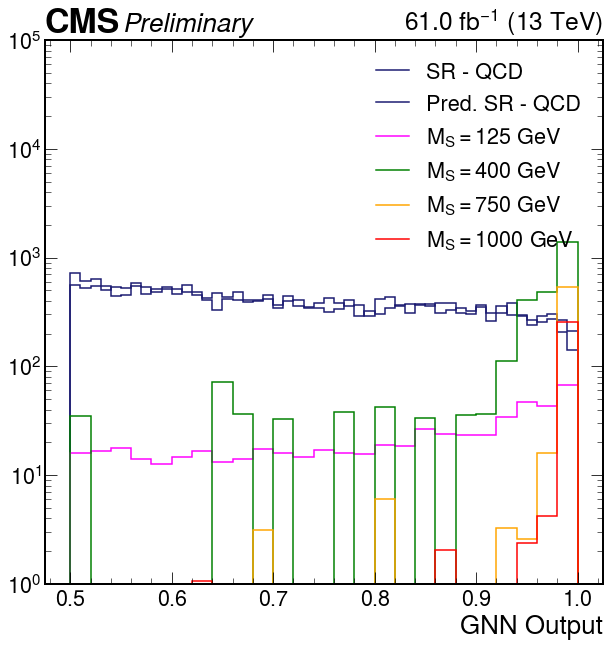

In [ ]:
plot_label = '2D_SUEP_S1_vs_single_l5_bPfcand_S1_SUEPtracks_GNN'
year = '2018'
abcd = plots['QCD_HT_'+year][plot_label]

xregions = [0.3j, 0.4j, 0.5j, 1.0j]
yregions = [0.0j, 0.5j, 1.0j]

SR, SR_exp = ABCD_6regions(abcd, xregions, yregions, sum_var='x')
_, SR_exp_data = ABCD_6regions(plots['data_'+year][plot_label], xregions, yregions, sum_var='x')

# use the custom plot_ratio
# the hist implementation used elsewhere in the notebook doesn't use the 
# errors in the hists' bins to calculate the errors in the ratio plot
# fig, axs, _ = plot_ratio(SR_exp, SR, 
#                          "# Constituents in SUEP", "$SR_{obs}$ - QCD", "$SR_{exp}$ - Data")
# _ = axs[1].set_ylim(0,3.0)
# _ = axs[0].legend()

fig, ax = plt.subplots(figsize=(10, 10))
hep.cms.label(llabel='Preliminary',data=False, lumi=lumiLabel(year))
hep.histplot(SR_exp_data, yerr=False, label="Pred. SR - Data", color=default_colors['data'])    
hep.histplot(SR, yerr=False, label="SR - QCD", color=default_colors['QCD'])    
hep.histplot(SR_exp, yerr=False, label="Pred. SR - QCD", color=default_colors['QCD'])    

samples = ['SUEP-m125-generic-htcut', 'SUEP-m400-generic',
          'SUEP-m750-generic', 'SUEP-m1000-generic']
labels = [r'$M_{S}=125$ GeV',r'$M_{S}=400$ GeV',r'$M_{S}=750$ GeV',r'$M_{S}=1000$ GeV']
for sample, label in zip(samples, labels):
    abcd = plots[sample][plot_label]
    SUEP_SR = abcd[0.5j:1.0j:sum,0.5j:1.0j:2j]
    hep.histplot(SUEP_SR, yerr=False, label=label, color=default_colors[sample])    

plt.legend(loc='best')
plt.yscale("log")
plt.ylim(1e0,1e5)

if saveToAN: plt.savefig(AN_label.format("ML_final_"+year))
plt.savefig(output_label+"ML_final_"+year+file_ext)

## ABCD - 1D Correlation

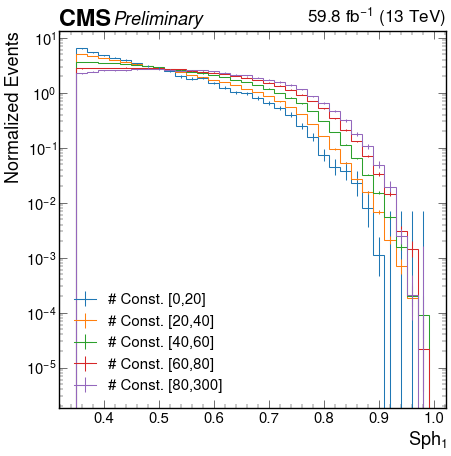

In [18]:
# parameters
plot_label = '2D_SUEP_S1_vs_SUEP_nconst_Cluster'
year = '2018'
sample = 'QCD_HT_'+year

fig, ax = plt.subplots(figsize=(10, 10))
hep.cms.label(llabel='Preliminary',data=False, lumi=round(lumiLabel(year),1))

slices = [[0j,20j],[20j,40j],[40j,60j],[60j,80j],[80j,300j]]
for j in range(len(slices)):
    val_lo = slices[j][0]
    val_up = slices[j][1]

    h = plots[sample][plot_label][0.35j::2j,val_lo:val_up:sum]

    hep.histplot(h,
                 yerr=True, density=True, 
                 label="# Const. [{0},{1}]".format(round(val_lo.imag), round(val_up.imag)))    

plt.legend()
#plt.ylim(1e-6,1e0)
plt.yscale('log')
plt.ylabel("Normalized Events")
plt.xlabel(r"$Sph_{1}$")

if saveToAN: plt.savefig(AN_label.format("1D_decorrelate_" + year))
plt.savefig(output_label + "1D_decorrelate_" + year + file_ext,  bbox_inches='tight')
plt.show()

## ABCD - data/MC Control Regions

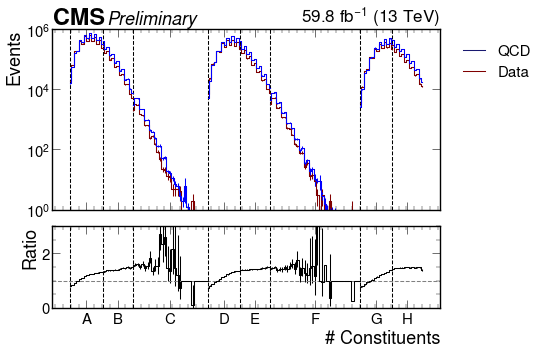

In [20]:
x = 'ABCDEFGH'
y = 'ADGBEHCF'
year = '2018'
plot_labels = ['SUEP_nconst_Cluster']
for plot_label in plot_labels:
    fig, (ax1, ax2) = plot_ratio_regions(plots, 'A_'+plot_label, 
                           'data_'+year, 'QCD_HT_'+year,
                           x, density=False)
    ax1.legend(labels=['QCD','Data'], loc='upper left', bbox_to_anchor=(1.02, 1))
    hep.cms.label(llabel='Preliminary', data=False, lumi=lumiLabel(year), ax=ax1)

    ax1.set_ylim(1e0, 1e6)
    ax2.set_ylim(0, 3)

    if saveToAN: plt.savefig(AN_label.format("control_regions_ratio_" + year))
    fig.savefig(output_label + 'control_regions_ratio_' + year + file_ext, bbox_inches='tight')

In [ ]:
x = 'ABCDE'
y = 'ABCDE'
year = '2018'
plot_labels = ['single_l5_bPfcand_S1_SUEPtracks_GNN']
for plot_label in plot_labels:
    fig, (ax1, ax2) = plot_ratio_regions(plots, 'A_'+plot_label, 
                           'data_'+year, 'QCD_HT_'+year,
                           y, density=False)
    ax1.legend(labels=['QCD','Data'], loc='upper left', bbox_to_anchor=(1.02, 1))
    hep.cms.label(llabel='Preliminary', data=False, lumi=lumiLabel(year), ax=ax1)

    ax1.set_ylim(1e0, 2e5)
    fig.set_size_inches(15, 6)
    
    if saveToAN: fig.savefig(AN_label.format("ML_control_regions_ratio_" + year))
    fig.savefig(output_label + 'ML_control_regions_ratio_' + year + file_ext, bbox_inches='tight')

## ABCD - Contamination Control Regions

In [5]:
mu = 1448.16781/34.8

plots['scaled_M125_2018'] = fill_utils.apply_normalization(plots['M125_2018'], mu)

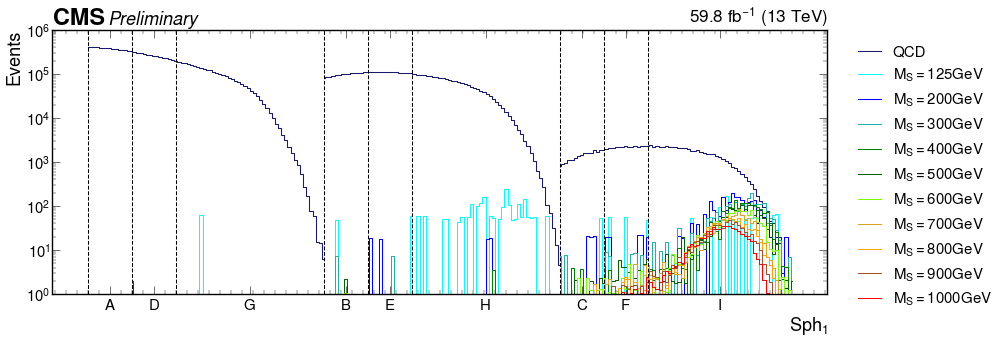

In [22]:
x = 'ABCDEFGHI'
y = 'ADGBEHCFI'
year = '2018'
plot_labels = ['SUEP_S1_Cluster']
samples = ['QCD_HT_'+year, 'M125_'+year, 'M200_'+year, 'M300_'+year, 'M400_'+year,
          'M500_'+year, 'M600_'+year, 'M700_'+year, 'M800_'+year, 'M900_'+year, 'M1000_'+year]
#samples = ['QCD_HT_'+year]
labels = ['QCD', r'$M_{S} = 125 GeV$', r'$M_{S} = 200 GeV$', r'$M_{S} = 300 GeV$',
         r'$M_{S} = 400 GeV$', r'$M_{S} = 500 GeV$', r'$M_{S} = 600 GeV$', r'$M_{S} = 700 GeV$',
         r'$M_{S} = 800 GeV$', r'$M_{S} = 900 GeV$', r'$M_{S} = 1000 GeV$']
for plot_label in plot_labels:

    fig, ax = plot_all_regions(plots, 'A_'+plot_label, samples, 
                               labels=labels, regions=y, density=False)
    hep.cms.label(llabel='Preliminary', data=False, lumi=lumiLabel(year), ax=ax)

    ax.set_ylim(1e0, 1e6)
    ax.set_xlabel(r"$Sph_1$")

    if saveToAN: fig.savefig(AN_label.format('contamination_'+year), bbox_inches='tight')
    fig.savefig(output_label + 'contamination_' + year + file_ext, bbox_inches='tight')

## Contamination Table

In [23]:
plot_label = 'SUEP_S1_Cluster'

samples = ['M125', 'M400',
          'M700', 'M1000']
labels = ['$m_{S} = 125 \GeV$', '$m_{S} = 400 \GeV$',
          '$m_{S} = 700 \GeV$', '$m_{S} = 1000 \GeV$']
regions = 'ABCDE'

for year in ['2018']:
    QCD_sample = 'QCD_HT_'+year
    for label, sample in zip(labels, samples):
        line = label + ' & '
        sample += "_"+year
        for i, region in enumerate(regions):
            h = plots[sample][region + "_" + plot_label]
            total = h.sum().value
            line += '$' + str(round(total)) + '\\pm' + str(round(np.sqrt(total))) + '$'

            if i == len(regions)-1: line += ' \\\\'
            else: line += ' & '
        print(line)
    print()

$m_{S} = 125 \GeV$ & $0\pm0$ & $47\pm7$ & $53\pm7$ & $0\pm0$ & $59\pm8$ \\
$m_{S} = 400 \GeV$ & $0\pm0$ & $0\pm0$ & $8\pm3$ & $0\pm0$ & $0\pm0$ \\
$m_{S} = 700 \GeV$ & $0\pm0$ & $0\pm0$ & $5\pm2$ & $1\pm1$ & $0\pm0$ \\
$m_{S} = 1000 \GeV$ & $0\pm0$ & $0\pm0$ & $1\pm1$ & $0\pm0$ & $0\pm0$ \\



In [24]:
regions = 'ABCDEFGH'

for year in ['2018']:
    QCD_sample = 'QCD_HT_'+year
    for label, sample in zip(labels, samples):
        line = label + ' & '
        sample += "_"+year
        for i, region in enumerate(regions):
            h = plots[sample][region + "_" + plot_label]
            hQCD = plots[QCD_sample][region + "_" + plot_label]
            alpha = h.sum().value
            beta = hQCD.sum().value
            total = alpha/beta * 100
            err = np.sqrt(alpha * (beta**-2) + (alpha**2) * (beta**-3)) * 100
            line += '$' + str(round(total,2)) + '\\pm' + str(round(err,2)) + '$'

            if i == len(regions)-1: line += ' \\\\'
            else: line += ' & '
        print(line)
    print()

$m_{S} = 125 \GeV$ & $0.0\pm0.0$ & $0.0\pm0.0$ & $0.25\pm0.03$ & $0.0\pm0.0$ & $0.0\pm0.0$ & $0.49\pm0.04$ & $0.0\pm0.0$ & $0.11\pm0.0$ \\
$m_{S} = 400 \GeV$ & $0.0\pm0.0$ & $0.0\pm0.0$ & $0.04\pm0.01$ & $0.0\pm0.0$ & $0.0\pm0.0$ & $0.03\pm0.01$ & $0.0\pm0.0$ & $0.0\pm0.0$ \\
$m_{S} = 700 \GeV$ & $0.0\pm0.0$ & $0.0\pm0.0$ & $0.02\pm0.01$ & $0.0\pm0.0$ & $0.0\pm0.0$ & $0.08\pm0.02$ & $0.0\pm0.0$ & $0.0\pm0.0$ \\
$m_{S} = 1000 \GeV$ & $0.0\pm0.0$ & $0.0\pm0.0$ & $0.01\pm0.01$ & $0.0\pm0.0$ & $0.0\pm0.0$ & $0.04\pm0.01$ & $0.0\pm0.0$ & $0.0\pm0.0$ \\



In [24]:
#ML

regions = 'ABCDE'

for year in ['2018']:
    QCD_sample = 'QCD_HT_'+year
    for label, sample in zip(labels, samples):
        line = label + ' & '
        for i, region in enumerate(regions):
            h = plots[sample][region + "_" + plot_label]
            hQCD = plots[QCD_sample][region + "_" + plot_label]
            alpha = h.sum().value
            beta = hQCD.sum().value
            total = alpha/beta * 100
            err = np.sqrt(alpha * (beta**-2) + (alpha**2) * (beta**-3)) * 100
            line += '$' + str(round(total,2)) + '\\pm' + str(round(err,2)) + '$'

            if i == len(regions)-1: line += ' \\\\'
            else: line += ' & '
        print(line)
    print()

QCD & $100.0\pm0.07$ & $100.0\pm1.01$ & $100.0\pm0.08$ & $100.0\pm1.18$ & $100.0\pm0.06$ \\
$M_{S} = 125 GeV$ & $0.0\pm0.0$ & $0.14\pm0.03$ & $0.0\pm0.0$ & $0.25\pm0.04$ & $0.04\pm0.0$ \\
$M_{S} = 400 GeV$ & $0.0\pm0.0$ & $0.35\pm0.04$ & $0.0\pm0.0$ & $0.5\pm0.06$ & $0.0\pm0.0$ \\
$M_{S} = 750 GeV$ & $0.0\pm0.0$ & $0.03\pm0.01$ & $0.0\pm0.0$ & $0.09\pm0.02$ & $0.0\pm0.0$ \\
$M_{S} = 1000 GeV$ & $0.0\pm0.0$ & $0.01\pm0.01$ & $0.0\pm0.0$ & $0.05\pm0.02$ & $0.0\pm0.0$ \\



## ML Systematic

In [ ]:
# parameters
plot_label = '2D_ISR_S1_vs_single_l5_bPfcand_S1_SUEPtracks_GNNInverted'
sample1 = 'QCD_HT_2018'
sample2 = 'data_2018'

h1 = plots[sample1][plot_label]
h2 = plots[sample2][plot_label]

h1 = h1[0.0j::sum, 0.0j::5j]
h2 = h2[0.0j::sum, 0.0j::5j]

fig = plt.figure(figsize=(10, 8))
      
fig, axs, _ = plot_ratio([h1, h2] labels=[r'QCD - $H_T$ Binned', 'Data'])
axs[0].legend()
axs[1].set_ylim(0.5,2.5)
#axs[0].set_yscale("linear")
cms = axs[0].text(
    -0.25, 4.5e7, u"CMS $\it{Preliminary}$",
    fontsize=24, fontweight='bold',
)
lumi = axs[0].text(
    0.78, 4.5e7, r"%.1f fb$^{-1}$ (13 TeV)" % round(lumis[year]/1000,1),
    fontsize=22, 
)
plt.savefig(AN_label.format("ML_systematic_"+year))

## Systematic Uncertainties

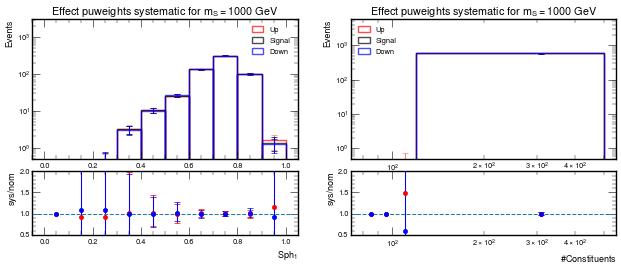

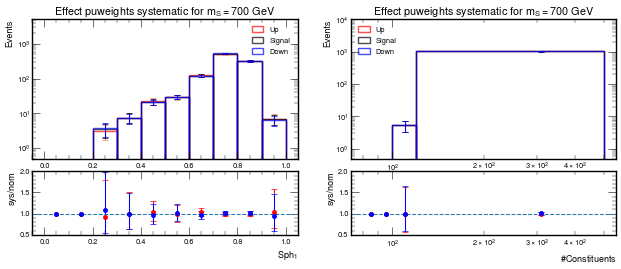

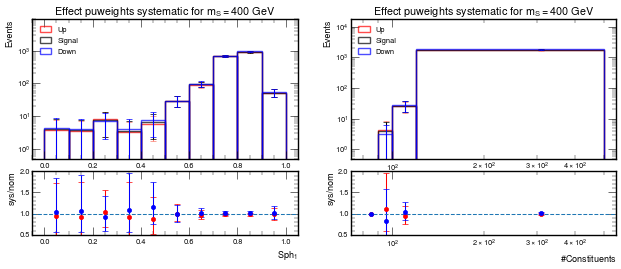

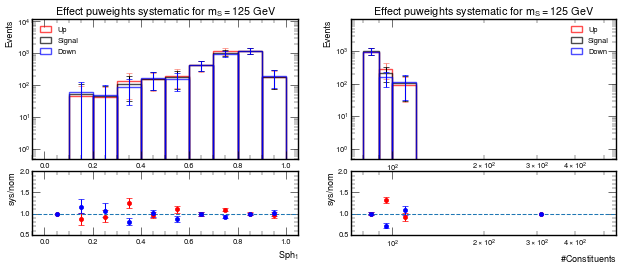

In [26]:
sys_list =  ['puweights'] #['track','JER','JES','trigSF','PSWeight_ISR','PSWeight_FSR','prefire','higgs_weights']
mass_list = [1000,700,400,125]
decay_list = ['generic','darkPho','darkPhoHad']
decay = 'generic'

nconst_bins = [80, 90, 100, 120, 500]
sph_bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

plt.rcParams.update({'font.size': 13})

for mass in mass_list:
    # print('mass', mass)
    
    plot = plots['M{}_2018'.format(str(mass),decay)]
    
    for sys in sys_list:

        sig_nconst = plot['SUEP_nconst_Cluster']
        up_nconst = plot['SUEP_nconst_Cluster_{}_up'.format(sys)]
        down_nconst = plot['SUEP_nconst_Cluster_{}_down'.format(sys)]

        sig_sph = plot['SUEP_S1_Cluster']
        up_sph = plot['SUEP_S1_Cluster_{}_up'.format(sys)]
        down_sph = plot['SUEP_S1_Cluster_{}_down'.format(sys)]


        # Change the bin sizes

        sig_nconst = rebin_piecewise(sig_nconst, nconst_bins)
        up_nconst = rebin_piecewise(up_nconst, nconst_bins)
        down_nconst = rebin_piecewise(down_nconst, nconst_bins)

        sig_sph = rebin_piecewise(sig_sph, sph_bins)
        up_sph = rebin_piecewise(up_sph, sph_bins)
        down_sph = rebin_piecewise(down_sph, sph_bins)

        plt.figure(figsize=(16,8))
        plt.gcf().subplots_adjust(bottom=0.15, left=0.17)


        ### Plot distribution for number of constituents

        # Plot histograms of systematics 
        up,down,sig = up_sph,down_sph,sig_sph
        ax1 = plt.subplot2grid((4,2), (0,0),rowspan=2)
        ax1.bar(*up.axes.centers, up.values(), width=up.axes.widths[0],yerr=up.variances()**0.5,fill=False,color= 'salmon',edgecolor='red',linewidth=2,alpha =0.7,label='Up',capsize=4,ecolor = 'salmon')
        ax1.bar(*sig.axes.centers, sig.values(), width=sig.axes.widths[0], yerr=sig.variances()**0.5,fill=False,linewidth=2,color= 'grey',edgecolor='black',alpha=0.7, label='Signal',capsize=4, ecolor='black')
        ax1.bar(*down.axes.centers, down.values(), width=down.axes.widths[0],yerr=down.variances()**0.5,color= 'lightblue',fill=False,edgecolor='blue',alpha=0.7,linewidth=2,label='Down',capsize=4,ecolor='blue')
        ax1.set_title("Effect "+sys+ " systematic for $m_{S}=$"+str(mass)+ " GeV")
        ax1.set_ylim([0.5,max(sig.values())*10])
        ax1.set_ylabel("Events")
        ax1.set_yscale('log')
        ax1.legend() 


        # Make ratio plot
        up_ratio = np.divide( up.values(), sig.values(), out=np.ones_like(up.values()), where=sig.values()!=0) #Overestimate
        down_ratio = np.divide( down.values(), sig.values(), out=np.ones_like(down.values()), where=sig.values()!=0) #Underestimate

        #Calculate errors in up_ratio and down_ratio
        up_err = hist.intervals.ratio_uncertainty(up.values(),sig.values()) #This ratio uncertainty is the poisson interval (for a coverage of 0.68) divided by sig
        down_err = hist.intervals.ratio_uncertainty(down.values(),sig.values())

        ax2 = plt.subplot2grid((4,2), (2,0),sharex=ax1)
        ups = ax2.errorbar(*sig.axes.centers, up_ratio,fmt='o', color='red', label = 'up',yerr= up_err,capsize=4)
        downs = ax2.errorbar(*sig.axes.centers, down_ratio,fmt='o', color='blue', label = 'down',yerr= down_err,capsize=4)
        ax2.axhline(1,ls='--')
        ax2.set_ylim([0.5,2.0])
        ax2.set_xlabel('$Sph_1$')
        ax2.set_ylabel('sys/nom')


        ### Plot distribution for number of sphericity

        # Plot histograms of systematics 
        up,down,sig = up_nconst,down_nconst,sig_nconst
        ax3 = plt.subplot2grid((4,2), (0,1),rowspan=2)
        ax3.bar(*up.axes.centers, up.values(), width=up.axes.widths[0],yerr=up.variances()**0.5,fill=False,color= 'salmon',edgecolor='red',linewidth=2,alpha =0.7,label='Up',capsize=4,ecolor = 'salmon')
        ax3.bar(*sig.axes.centers, sig.values(), width=sig.axes.widths[0], yerr=sig.variances()**0.5,fill=False,linewidth=2,color= 'grey',edgecolor='black',alpha=0.7, label='Signal',capsize=4, ecolor='black')
        ax3.bar(*down.axes.centers, down.values(), width=down.axes.widths[0],yerr=down.variances()**0.5,color= 'lightblue',fill=False,edgecolor='blue',alpha=0.7,linewidth=2,label='Down',capsize=4,ecolor='blue')
        ax3.set_title("Effect "+sys+ " systematic for $m_{S}=$"+str(mass) +" GeV")
        ax3.set_ylim([0.5,max(sig.values())*10])
        ax3.set_ylabel("Events")
        ax3.set_yscale('log')
        ax3.legend()


        # Make ratio plot
        up_ratio = np.divide( up.values(), sig.values(), out=np.ones_like(up.values()), where=sig.values()!=0) #Overestimate
        down_ratio = np.divide( down.values(), sig.values(), out=np.ones_like(down.values()), where=sig.values()!=0) #Underestimate

        #Calculate errors in up_ratio and down_ratio
        up_err = hist.intervals.ratio_uncertainty(up.values(),sig.values()) #This ratio uncertainty is the poisson interval (for a coverage of 0.68) divided by sig
        down_err = hist.intervals.ratio_uncertainty(down.values(),sig.values())

        ax4 = plt.subplot2grid((4,2), (2,1),sharex=ax3)
        ups = ax4.errorbar(*sig.axes.centers, up_ratio,fmt='o', color='red', label = 'up',yerr= up_err,capsize=4)
        downs = ax4.errorbar(*sig.axes.centers, down_ratio,fmt='o', color='blue', label = 'down',yerr= down_err,capsize=4)
        ax4.axhline(1,ls='--')
        ax4.set_ylim([0.5,2.0])
        ax4.set_xlabel("$\# Constituents$")
        ax4.set_ylabel('sys/nom')
        ax4.set_xscale('log')
        
        #plt.savefig(AN_label.format('systematic_variations_' + sys +'_mS' + str(mass)),bbox_inches='tight')
        
        plt.savefig(output_label + 'systematic_variations_' + sys +'_mS' + str(mass), bbox_inches='tight')
        plt.show()


# print('done')